In [ ]:
from typing import Generic, Optional, Tuple, List, Callable, Iterable, Mapping

import numpy as np
from torchvision.models import resnet50
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import utils
from utils import debugt, debugs, debug

torch.hub.set_dir('torch_cache')
import fishdetr_batchboy as detr
import contextlib
from generators import TorchStereoDataset
import re
from matplotlib import pyplot as plt
import plotly.express as px

import sys
sys.path.append('./detr_custom/')
from models.matcher import HungarianMatcher
from models.detr import SetCriterion
import os

In [2]:
debugt = utils.reloader(debugt)

In [3]:
utils.seed_everything(42069)

try:
    device = utils.pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
    print(utils.get_cuda_status(device))
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

Using device: cuda:1 (GeForce RTX 2080 Ti)
GeForce RTX 2080 Ti 
Memory usage:
Allocated: 0.0 GB
Cached   : 0.0 GB


In [4]:
DATA_DIR = '/mnt/blendervol/leftright_left_data'
TABLE = 'bboxes_std'
BATCH_SIZE = 1

In [5]:
utils.reloader(detr)

traingen = TorchStereoDataset(DATA_DIR, TABLE, shuffle=False, imgnrs=range(8,8+BATCH_SIZE))

loader = torch.utils.data.DataLoader(
    traingen,
    batch_size=BATCH_SIZE,
    collate_fn=detr.collate
)

X, y = next(iter(loader))
trans = T.Compose([T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
X[0], X[1] = trans(X[0]).to(device), trans(X[1]).to(device)
y = detr.label_handler(y, device)

In [6]:
debugs(X[0])

(1, <module>) X[0]: torch.Size([1, 3, 416, 416])


In [7]:
utils.reloader(detr)
model = detr.FishDETR(freeze_encoder=False).to(device)

Encoder successfully loaded with pretrained weights


In [8]:
@utils.interruptable
def train_head(model, X, y, epochs: int=1):        
    weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
    losses = ['labels', 'boxes', 'cardinality']
    matcher = HungarianMatcher()
    criterion = SetCriterion(6, matcher, weight_dict, 0.5, losses).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
#     model.decoder.train()
    model.train()
    criterion.train()
    
    running_train_loss = 0.0
    for epoch in range(1,epochs+1):
        output = model(X)
        loss_dict = criterion(output, y)
        weight_dict = criterion.weight_dict
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        optimizer.zero_grad()
        losses.backward() # Computes gradients
        optimizer.step() # Do a gradient step
        
        running_train_loss += losses.item()
        train_loss = running_train_loss / (epoch)
        
        if not epoch % 20: 
            print(losses.item())
            
    return output

output = train_head(model, X, y, 20000)

1.566584825515747
1.0690356492996216
0.5358203053474426
0.7193427085876465
0.6294716000556946
0.8962153196334839
0.646956205368042
0.651076078414917
0.6446353197097778
0.7080804109573364
0.6274400949478149
0.6803396940231323
0.5893349647521973
0.5977454781532288
0.8578062653541565
0.3213579058647156
0.3047405481338501
0.19995060563087463
0.22189578413963318
0.23158876597881317
0.14896351099014282
0.14030008018016815
0.05525676906108856
0.09679818153381348
0.05992468446493149
0.08805916458368301
0.13047391176223755
0.0390436127781868
0.06141041964292526
0.05479104071855545
0.05728796869516373
0.05281447991728783
0.07591813057661057
0.056522175669670105
Process interrupted


In [ ]:
# utils.save_model(model, 'batch_overfit.pth')

In [ ]:
utils.reloader(detr)

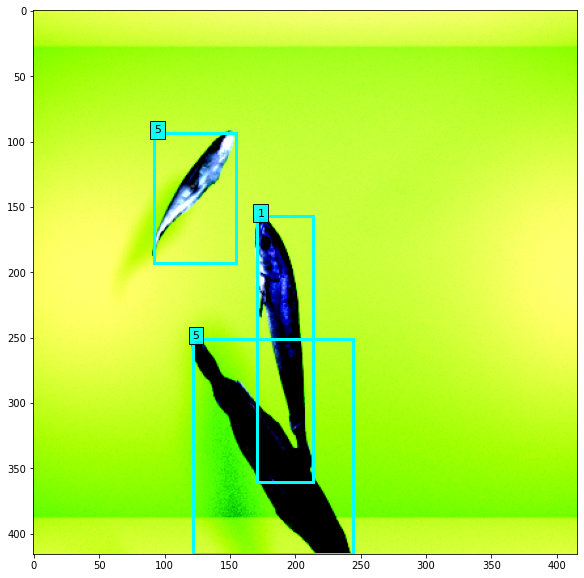

In [11]:
@torch.no_grad()
def bobo(model, X: Tuple[torch.Tensor, torch.Tensor]):
    model = model.eval()
    output = model(X)
    boxess = output['pred_boxes']
    logitss = output['pred_logits']
    for left, right, boxes, logits in zip(X[0], X[1], boxess, logitss):
        logits_, boxes_ = detr.postprocess(logits, boxes)
        plot_results(left.cpu().permute((1,2,0)), logits_, boxes_) 
    
bobo(model, X)

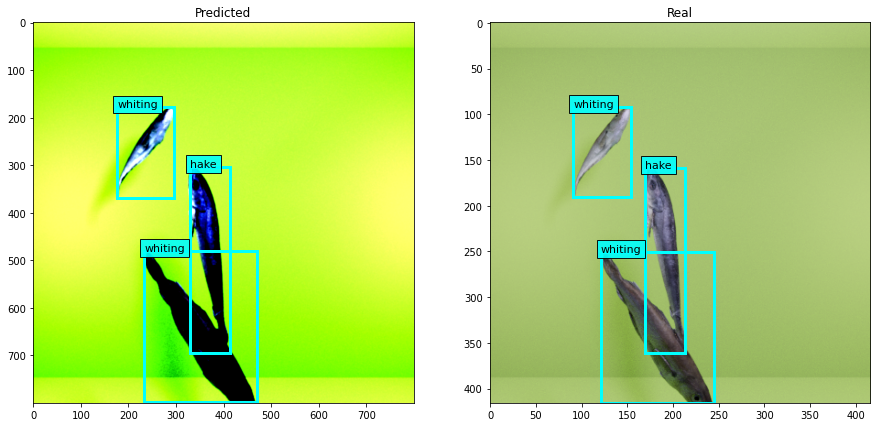

In [10]:
def box_cxcywh_to_xyxy(x: torch.Tensor):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def plot_results(img, classes: Iterable, boxes: Iterable, classmap: Optional[Mapping[int, str]]=None, ax: Optional=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(16,10))
        
    img = np.array(img)
    ax.imshow(img.clip(0,1))
    
    if len(boxes) != 0:
        h, w = img.shape[:2]
        boxes = box_cxcywh_to_xyxy(boxes)
        boxes[:,[0,2]] *= w
        boxes[:,[1,3]] *= h
        
        for cls, (xmin, ymin, xmax, ymax) in zip(classes, boxes):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                       fill=False, color='cyan', linewidth=3))
            try:
                strcls = classmap[int(cls)]
            except:
                strcls = str(int(cls))
                    
            ax.text(xmin, ymin, strcls, fontsize=11, bbox=dict(facecolor='cyan', alpha=0.9))
    
    if ax is None:
        ax.axis('off')
        plt.show()
        
    return ax

    
def eval_model(model, img: torch.Tensor, classmap: Optional[Mapping[int, str]]=None, ax: Optional=None):
    with torch.no_grad():
        model.eval()
        
        output = model((img[0].to(device), img[1].to(device)))
        
        boxes = output['pred_boxes'][0]
        logits = output['pred_logits'][0]
        
        logits_, boxes_ = detr.postprocess(logits, boxes)
        
        plot_results(img[0][0].cpu().numpy().transpose((1,2,0)), logits_, boxes_, classmap, ax=ax)
        
        
def eval_compare_model(model: nn.Module, gen: Iterable, index: int=0, classmap: Optional[Mapping[int, str]]=None):
    x, y = gen[index]
    fig, axes = plt.subplots(1,2,figsize=(15,7))
    eval_model(model, detr.img_handler([x])[0], classmap, axes[0])
    plot_results(x[0][0].cpu().numpy().transpose((1,2,0)), y['labels'], y['boxes'], classmap, axes[1])
    axes[0].set_title('Predicted')
    axes[1].set_title('Real')

num2name = eval(open(os.path.join(DATA_DIR,"metadata.txt"), 'r').read())
for i in range(BATCH_SIZE):
    eval_compare_model(model, traingen, index=i, classmap=num2name)
    plt.show()
    